In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/dataset/Multi-Modal_Glaucoma_Model.zip"
extract_path = "/content"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction complete! Files are now in: {extract_path}")


Extraction complete! Files are now in: /content


In [3]:
import pandas as pd

# Path to your CSV file
csv_path = "/content/Shared/metadata - standardized.csv"

# Read the CSV file
df = pd.read_csv(csv_path)

# Display the first few rows
df.head()
df.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [4]:
df["image_path"] = df["fundus"].apply(lambda x: x.replace("/full-fundus", "/content/Fundus_task/full-fundus/full-fundus") if isinstance(x, str) else None)
df["vessel_path"] = df["bv_seg"].apply(
    lambda x: x.replace("/blood-vessel", "/content/Fundus_task/blood-vessel/blood-vessel") if isinstance(x, str) else None
)


In [5]:

# Keep only the required columns
df2 = df[[
 "image_path",
 "vessel_path",
]]

In [6]:
df2.dropna()

,image_path,vessel_path
4494,/content/Fundus_task/full-fundus/full-fundus/H...,/content/Fundus_task/blood-vessel/blood-vessel...
4495,/content/Fundus_task/full-fundus/full-fundus/H...,/content/Fundus_task/blood-vessel/blood-vessel...
4496,/content/Fundus_task/full-fundus/full-fundus/H...,/content/Fundus_task/blood-vessel/blood-vessel...
4497,/content/Fundus_task/full-fundus/full-fundus/H...,/content/Fundus_task/blood-vessel/blood-vessel...
4498,/content/Fundus_task/full-fundus/full-fundus/H...,/content/Fundus_task/blood-vessel/blood-vessel...
...,...,...
12444,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12445,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12446,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12447,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...


In [7]:
df2 = df2.dropna()

In [8]:
df2.tail(200)

,image_path,vessel_path
12249,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12250,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12251,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12252,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12253,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
...,...,...
12444,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12445,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12446,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...
12447,/content/Fundus_task/full-fundus/full-fundus/F...,/content/Fundus_task/blood-vessel/blood-vessel...


In [10]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
import pandas as pd

# --- CONFIG ---
ORIG_SIZE = 512
PATCH_SIZE = 256
AUG_PER_IMAGE = 3  # how many augmented samples to generate per image
SAVE_DIR = "/content/drive/MyDrive/Preprocessed_Vessels"
os.makedirs(os.path.join(SAVE_DIR, "images"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "masks"), exist_ok=True)

# --- ENHANCE IMAGE ---
def enhance_image(image):
    # Use green channel for better vessel contrast
    green_channel = image[:, :, 1]

    # Apply CLAHE to green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green_channel)

    # Unsharp masking for vessel enhancement
    blur = cv2.GaussianBlur(enhanced, (0, 0), sigmaX=2)
    unsharp = cv2.addWeighted(enhanced, 1.5, blur, -0.5, 0)

    # Normalize contrast to 0-255
    unsharp = cv2.normalize(unsharp, None, 0, 255, cv2.NORM_MINMAX)

    # Convert back to 3-channel BGR
    enhanced_bgr = cv2.cvtColor(unsharp.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    return enhanced_bgr

# --- PATCHING ---
def extract_patches(img, mask, patch_size):
    patches, mask_patches = [], []
    for i in range(0, ORIG_SIZE, patch_size):
        for j in range(0, ORIG_SIZE, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            m_patch = mask[i:i+patch_size, j:j+patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
                mask_patches.append(m_patch)
    return patches, mask_patches

# --- AUGMENTATION ---
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.4, shift_limit=0.05, scale_limit=0.05, rotate_limit=20),
    A.OneOf([
        A.ElasticTransform(),
        A.GridDistortion(),
        A.OpticalDistortion()
    ], p=0.2)
])

# --- LOAD DF ---
# Make sure df2 is defined before running this script.
# Example: df2 = pd.read_csv("your_dataframe.csv")
records = [(row['image_path'], row['vessel_path']) for _, row in df2.iterrows()]

image_patches = []
mask_patches = []


# --- PROCESSING LOOP ---
print(f"Processing {len(records)} images...")

for idx, (img_path, mask_path) in tqdm(enumerate(records), total=len(records)):
    image = enhance_image(cv2.imread(img_path))
    mask = cv2.imread(mask_path, 0)

    image = cv2.resize(image, (ORIG_SIZE, ORIG_SIZE))
    mask = cv2.resize(mask, (ORIG_SIZE, ORIG_SIZE))
    mask = (mask > 15).astype(np.float32)

    orig_patches, orig_masks = extract_patches(image, mask, PATCH_SIZE)

    # Save original patches
    for p, m in zip(orig_patches, orig_masks):
        image_patches.append(p.astype(np.uint8))
        mask_patches.append(np.expand_dims(m, axis=-1))

    # Augmented patches
    for _ in range(AUG_PER_IMAGE):
        for p, m in zip(orig_patches, orig_masks):
            augmented = augmenter(image=p, mask=m)
            a_img = augmented['image']
            a_mask = augmented['mask']
            image_patches.append(a_img.astype(np.uint8))
            mask_patches.append(np.expand_dims(a_mask, axis=-1))

# --- SAVE TO DISK ---
image_patches = np.array(image_patches)
mask_patches = np.array(mask_patches)

np.save(os.path.join(SAVE_DIR, "images/patches.npy"), image_patches)
np.save(os.path.join(SAVE_DIR, "masks/patches.npy"), mask_patches)

print("✅ Preprocessing complete. Saved to:")
print(f"→ Images: {image_patches.shape}, Masks: {mask_patches.shape}")


Processing 462 images...


100%|██████████| 462/462 [00:18<00:00, 24.96it/s]


✅ Preprocessing complete. Saved to:
→ Images: (7392, 256, 256, 3), Masks: (7392, 256, 256, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import numpy as np
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# --- Mixed Precision ---
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# --- Squeeze and Excite Block ---
def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# --- Build U-Net with SE blocks and MobileNetV2 ---
def build_model(input_shape=(256, 256, 3), dropout_rate=0.1):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Unfreeze all layers for better training
    for layer in base.layers:
        layer.trainable = True

    skips = [
        base.get_layer("block_1_expand_relu").output,
        base.get_layer("block_3_expand_relu").output,
        base.get_layer("block_6_expand_relu").output,
        base.get_layer("block_13_expand_relu").output,
    ]

    x = base.output
    for i, skip in enumerate(reversed(skips)):
        filters = 256 // (2 ** i)
        x = Conv2DTranspose(filters, 3, strides=2, padding="same", kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, skip])
        x = Conv2D(filters, 3, padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = squeeze_excite_block(x)
        x = SpatialDropout2D(dropout_rate * (i + 1))(x)
        x = Conv2D(filters, 3, padding="same", activation="relu", kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)

    x = Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = Conv2D(32, 3, padding="same", activation="relu")(x)
    x = Conv2D(16, 3, padding="same", activation="relu")(x)
    output = Conv2D(1, 1, activation="sigmoid", dtype='float32')(x)

    return Model(inputs=base.input, outputs=output)

# --- Metrics ---
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Generator without Augmentation ---
def data_generator(image_patches, mask_patches, batch_size=8):
    size = len(image_patches)
    while True:
        idx = np.random.permutation(size)
        for i in range(0, size, batch_size):
            batch_images = image_patches[idx[i:i+batch_size]] / 255.0
            batch_masks = mask_patches[idx[i:i+batch_size]]
            yield batch_images, batch_masks

# --- Load Data ---
image_patches = np.load("/content/drive/MyDrive/Preprocessed_Vessels/images/patches.npy")
mask_patches = np.load("/content/drive/MyDrive/Preprocessed_Vessels/masks/patches.npy")

# --- Split ---
X_train, X_val, Y_train, Y_val = train_test_split(image_patches, mask_patches, test_size=0.2, random_state=42)

# --- Model ---
model = build_model(input_shape=(256, 256, 3), dropout_rate=0.1)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', dice_coef, iou_coef])

# --- Callbacks ---
checkpoint = ModelCheckpoint('vessel_model_best.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# --- Train ---
history = model.fit(
    data_generator(X_train, Y_train, batch_size=8),
    validation_data=data_generator(X_val, Y_val, batch_size=8),
    epochs=60,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_val) // 8,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# --- Cleanup ---
gc.collect()
tf.keras.backend.clear_session()


<ipython-input-11-92c33bf5b4f2>:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Epoch 1/60
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9134 - dice_coef: 0.5157 - iou_coef: 0.4838 - loss: 0.3662
Epoch 1: val_loss improved from inf to 0.22289, saving model to vessel_model_best.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 218s 89ms/step - accuracy: 0.9135 - dice_coef: 0.5159 - iou_coef: 0.4840 - loss: 0.3660 - val_accuracy: 0.9414 - val_dice_coef: 0.5468 - val_iou_coef: 0.3952 - val_loss: 0.2229 - learning_rate: 1.0000e-04
Epoch 2/60
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9742 - dice_coef: 0.7989 - iou_coef: 0.7595 - loss: 0.1206
Epoch 2: val_loss improved from 0.22289 to 0.16039, saving model to vessel_model_best.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 113s 75ms/step - accuracy: 0.9742 - dice_coef: 0.7989 - iou_coef: 0.7595 - loss: 0.1206 - val_accuracy: 0.9522 - val_dice_coef: 0.6380 - val_iou_coef: 0.5086 - val_loss: 0.1604 - learning_rate: 1.0000e-04
Epoch 3/60
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9766 - dice_coef: 0.8176 - iou_co

In [11]:
model.save("vessel_model_final.keras")
print("✅ Final model saved as vessel_model_final.keras")


✅ Final model saved as vessel_model_final.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 458 variables whereas the saved optimizer has 462 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


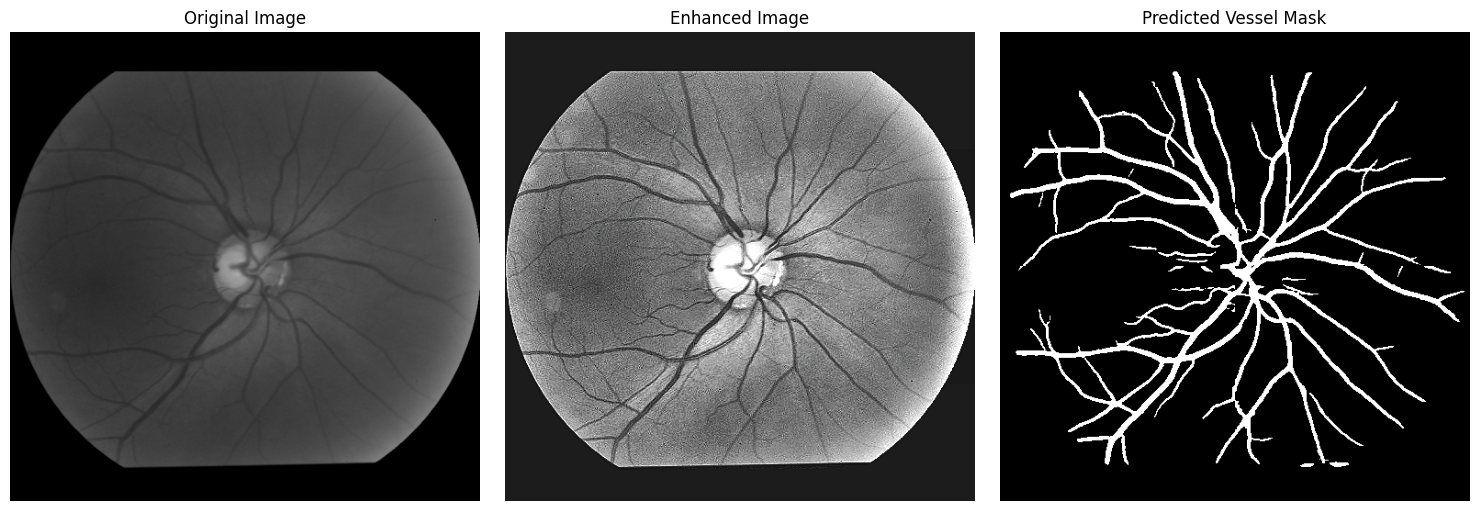

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Custom Metrics and Loss (must match training) ---
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_pos = tf.reduce_sum(y_true * y_pred)
    false_neg = tf.reduce_sum(y_true * (1 - y_pred))
    false_pos = tf.reduce_sum((1 - y_true) * y_pred)
    return 1 - (true_pos + 1e-6) / (true_pos + alpha * false_neg + beta * false_pos + 1e-6)

# --- Enhancement ---
def enhance_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    bgr = cv2.filter2D(bgr, -1, kernel)
    bgr = cv2.convertScaleAbs(bgr, alpha=1.3, beta=20)
    return bgr

# --- Patchify ---
def extract_patches(img, patch_size=256):
    h, w = img.shape[:2]
    patches = [
        img[i:i+patch_size, j:j+patch_size]
        for i in range(0, h, patch_size)
        for j in range(0, w, patch_size)
        if img[i:i+patch_size, j:j+patch_size].shape[:2] == (patch_size, patch_size)
    ]
    return patches

# --- Reconstruct mask ---
def reconstruct_mask(patches, full_size=(512, 512), patch_size=256):
    mask = np.zeros(full_size, dtype=np.float32)
    idx = 0
    for i in range(0, full_size[0], patch_size):
        for j in range(0, full_size[1], patch_size):
            if idx < len(patches):
                mask[i:i+patch_size, j:j+patch_size] = patches[idx]
                idx += 1
    return mask

# --- Load the trained model ---
model = load_model(
    "/content/vessel_model_best.keras",
    custom_objects={"dice_coef": dice_coef, "iou_coef": iou_coef, "tversky_loss": tversky_loss}
)

# --- Load & Enhance Image ---
img_path = "/content/Fundus_task/full-fundus/full-fundus/BEH-125.png"
orig_img = cv2.imread(img_path)
enh_img = enhance_image(orig_img)
enh_img = cv2.resize(enh_img, (512, 512))

# --- Patchify ---
patches = extract_patches(enh_img, patch_size=256)
input_patches = np.array(patches) / 255.0

# --- Ensure input shape ---
if input_patches.ndim == 3:
    input_patches = np.expand_dims(input_patches, axis=-1)
if input_patches.shape[-1] == 1:
    input_patches = np.repeat(input_patches, 3, axis=-1)

# --- Predict ---
preds = model.predict(input_patches, verbose=1)

# --- Binarize predictions ---
binary_preds = [(pred.squeeze() > 0.5).astype(np.float32) for pred in preds]

# --- Resize if needed ---
for i in range(len(binary_preds)):
    if binary_preds[i].shape != (256, 256):
        binary_preds[i] = cv2.resize(binary_preds[i], (256, 256))

# --- Reconstruct mask ---
full_mask = reconstruct_mask(binary_preds, full_size=(512, 512), patch_size=256)

# --- Visualize ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Enhanced Image")
plt.imshow(cv2.cvtColor(enh_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Vessel Mask")
plt.imshow(full_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
print(f"Total patches extracted: {len(patches)}")
print(f"Prediction shape: {preds.shape}")


Total patches extracted: 4
Prediction shape: (4, 256, 256, 1)
